# Term2 Sprint17

## chapter2 Faster R-CNN

Faster R-CNNの実装を動かす。データはKaggleのシンプソンズデータセットを使用する。
また、同様のデータセットに対して、YOLOv3にても学習・推定を行ったが、そちらは別ファイルにまとめてある。

## シンプソンズデータセットのDL

In [0]:
!pip install kaggle

In [0]:
mkdir .kaggle

In [0]:
import json

token = {"username":"ishizucat","key":"7ad9397c01d417573ba83f57a190fc46"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [0]:
!chmod 600 /content/.kaggle/kaggle.json 

In [0]:
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

100% 1.08G/1.08G [00:29<00:00, 28.4MB/s]



In [0]:
#!unzip /content/the-simpsons-characters-dataset.zip  -d Simpsons

## Faster R-CNN サンプルモデルのDL

In [0]:
!git clone https://github.com/duckrabbits/ObjectDetection.git

Cloning into 'ObjectDetection'...
remote: Enumerating objects: 28, done.
remote: Total 28 (delta 0), reused 0 (delta 0), pack-reused 28
Unpacking objects: 100% (28/28), done.


In [0]:
mv Simpsons/simpsons_dataset ObjectDetection/

In [0]:
cd ObjectDetection/

/content/ObjectDetection


## 学習と推定

In [0]:
!python train.py -p annotation.txt --n_epochs 100 --n_iters 500

Using TensorFlow backend.
Parsing annotation files
Training images per class (19 classes) :
{'abraham_grampa_simpson': 687,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 650,
 'bg': 0,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 718,
 'kent_brockman': 213,
 'krusty_the_clown': 429,
 'lisa_simpson': 756,
 'marge_simpson': 629,
 'milhouse_van_houten': 210,
 'moe_szyslak': 403,
 'ned_flanders': 675,
 'nelson_muntz': 219,
 'principal_skinner': 614,
 'sideshow_bob': 201}
-------------------------------
path to config file : ./save/train_20191223-012658_config.pickle
-------------------------------









Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
i

以下、学習した重みファイルを使用して推定を行う。

In [0]:
!python predict.py -i ../Simpsons/kaggle_simpson_testset/kaggle_simpson_testset/ -c save/train_20191223-012658_config.pickle

Using TensorFlow backend.










2019-12-23 04:18:16.765154: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX512F
2019-12-23 04:18:16.769114: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2000160000 Hz
2019-12-23 04:18:16.769453: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa034000 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2019-12-23 04:18:16.769483: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2019-12-23 04:18:16.780501: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-12-23 04:18:16.879594: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

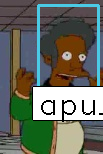

In [0]:
from IPython.display import Image,display_png
display_png(Image('/content/ObjectDetection/output/result_apu_nahasapeemapetilon_15.jpg.png'))


無事、検出することができた。

## 論文と実装の対応（コードリーディング）

fast R-CNNとの大きな違いは、faster R-CNNはRPNを組み込んでいる点である。
RPNの関数自体は、resnet.pyの中で以下のように記述されている。

In [0]:
def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]


この関数は、train.pyを実行した際に、

In [0]:
# train.py line:69
model_rpn, model_classifier, model_all = faster_rcnn.get_model(C, classes_count)

によってインスタンスが呼び出される。

C は、各種設定値がまとめられた config.pyのconfigクラスをインスタンス化したものである。

この中に、アンカーの生成に重要な情報として、以下が設定されている。

In [0]:
# config.py
# anchor box scales
self.anchor_box_scales = [64, 128, 256, 512]

# anchor box ratios
self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]

この設定値をもとに、faster_rcnn.pyの中でアンカーが初期化される。

In [0]:
# faster_rcnn.py line16-18
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn = nn.rpn(shared_layers, num_anchors)

アンカー情報がセットされた後、それぞれmodel_rpn, model_allに引き渡され、モデルとしてコンパイルされる。構造化されたモデルは、最終的にtrain.pyにてバッチデータが引き渡され、学習が進められる。


In [ ]:
#train.py line 97
loss_rpn = model_rpn.train_on_batch(X, Y)

以上